# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [153]:
from utils import get_dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
mpl.rcParams['figure.dpi'] = 300
#enable matplotlib in juypter
%matplotlib inline

In [2]:
dataset = get_dataset("data/waymo/training_and_validation/*")
#print(dataset)
#print(type(dataset))
#print(dir(dataset))

INFO:tensorflow:Reading unweighted datasets: ['data/waymo/training_and_validation/*']
INFO:tensorflow:Reading record datasets for input file: ['data/waymo/training_and_validation/*']
INFO:tensorflow:Number of filenames to read: 97
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [144]:
global_names = ["unknown", "vehicle", "pedestrian", "sign", "cyclist"]
global_counts = [0] * 5

def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    
    plt.figure(figsize=(50,20), dpi=300.0)
    #print(type(fig))
    
    curr_plot = 0
    for entry in batch:
        curr_plot += 1
        #print(curr_plot)
        plt.subplot(10, 1, curr_plot)
        add_image(entry)
        
    plt.tight_layout()
    plt.show()
    
    
def add_image(entry):
    #found in wymo docs during excersizes. 
    color_map = {
        0: [0, 0, 0], #black unknown
        1: [1, 0, 0], # red vechile
        2: [0, 1, 0], # green pedistrian
        3: [0, 0, 1], # blue sign
        4: [1, 1, 0], # yellow cyclist
    }
    
    #  enum Type {
    #TYPE_UNKNOWN = 0;
    #TYPE_VEHICLE = 1;
    #TYPE_PEDESTRIAN = 2;
    #TYPE_SIGN = 3;
    #TYPE_CYCLIST = 4;
    #}
    
    img = entry['image'].numpy()
    plt.imshow(img)
    #plt.figure(figsize=(3,3), dpi=300.0)
    #draw image
    #plt.imshow(entry['image'].numpy())
    plt.axis("on")
    #plt.show()
    #draw rectables
    ax = plt.gca()

    for bbclass,  bbox in zip(entry["groundtruth_classes"], entry["groundtruth_boxes"]):
        global global_counts
        #bbox values are 0-1, convert to pixles
        bbox = bbox * img.shape[0]
        y1, x1, y2, x2 = bbox
        xy = (x1, y1)
        width = x2 - x1
        height = y2 - y1
        
        bbclass = int(bbclass)
        global_counts[bbclass] += 1
        
        rect = patches.Rectangle(xy, width, height, linewidth=1, edgecolor=color_map[bbclass], facecolor='none')
        ax.add_patch(rect)
        

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

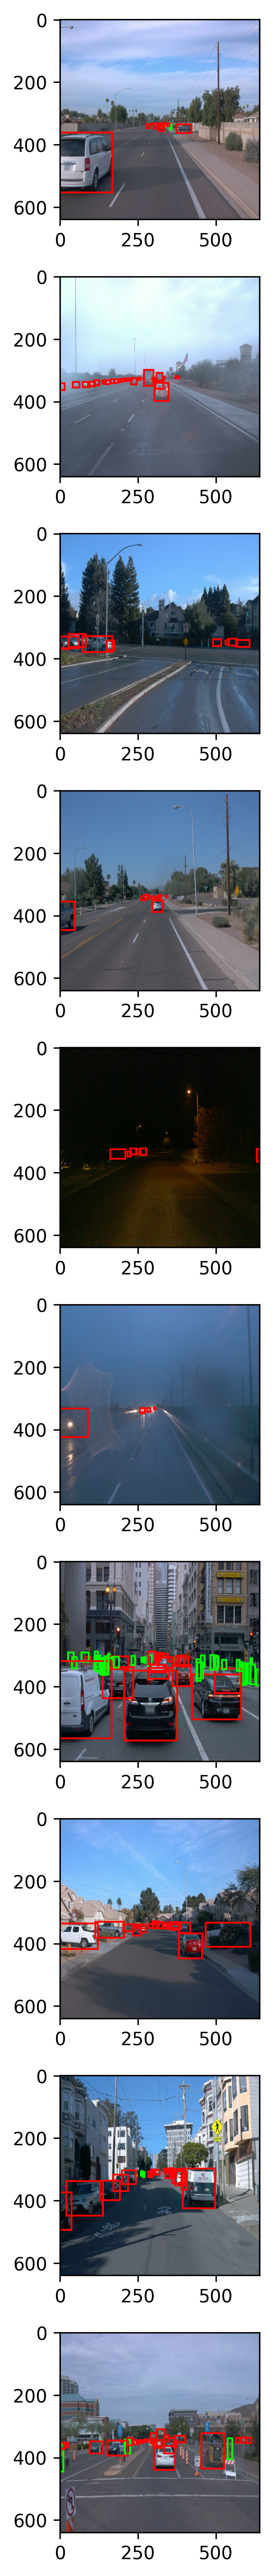

In [151]:
#reset stats
global_counts = [0] * 5

seed = 1 #testing set a seed
sampled_data = dataset.shuffle(100, seed)
display_instances(sampled_data.take(10))

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

First pass is a quick look at the distrubution of types in the currently selected data

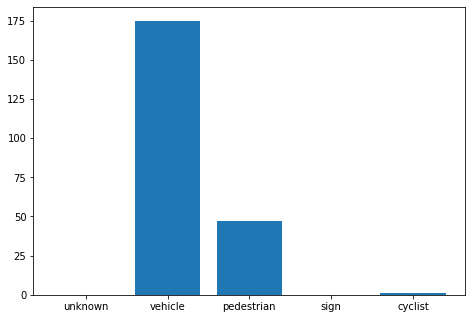

In [152]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(global_names, global_counts)
plt.show()


Grab a larger data set and count numbers in a big selection.
When we break out samples out we want the numbers to be fairly similar breakdown.

We will gather
total counts of each type
average size of each type

Future types could be average overlaps, ratio and ratio distribution, size distrobutions, etc. For now keeping the stats simple.

In [166]:
def area(bbox):
    ''' bbox should be in ratio units. This will return a % of area covered 0-1'''
    y1, x1, y2, x2 = bbox
    width = x2 - x1
    height = y2 - y1
    return width * height

def calc_stats(batch):
    count_type = [0]*5
    total_area_type = [0.0]*5
    total_obj = 0
    
    for entry in batch:
        for bbclass,  bbox in zip(entry["groundtruth_classes"], entry["groundtruth_boxes"]):
            bbclass = int(bbclass)
            count_type[bbclass] += 1
            total_area_type[bbclass] += area(bbox)
            total_obj +=1
            
    avg_area_type = np.divide(np.array(total_area_type), np.array(count_type), out=np.zeros_like(np.array(total_area_type)), where=np.array(count_type)!=0)
    type_ratio = np.divide(np.array(count_type), total_obj)
    
    return {"counts": count_type, "avg_area": avg_area_type, "total_obj": total_obj, "type_ratio": type_ratio}

    

In [ ]:
#stats = calc_stats(dataset.shuffle(100, seed).take(100))
stats = calc_stats(dataset)
print(stats)

fig, axs = plt.subplots(1, 2, constrained_layout=True)

ax = axs[0]
ax.bar(global_names, stats["type_ratio"])
ax.set_title("Ratio of types")

print()
ax = axs[1]
ax.set_title("Average Area of Types")
ax.bar(global_names, stats["avg_area"])
plt.show()
